<font size = 6 color = 'blue'>
<center> Notebook 1: Clasificador de rocas from scratch </center>

<font size = 5 color = 'blue'>
<center> Implementación de una Red Neuronal Artificial Convolucional para la clasificación de minerales </center>

<font size=5 color='black'>
    
La presentación tiene el siguiente índice: 
$$ $$
<font size=4 color='black'>

1.- Bibliotecas y configuración de la sesión
    
2.- Procesamiento de los datos
<ul>
    <li>2.1 Obtener los datos.
    <li>2.2 Procesamiento.
    <li>2.3 Normalización.
    <li>2.4 Generación de las etiquetas.
    <li>2.5 Reordenamiento aleatorio.
</ul>

3.- Separación de los datos en los conjuntos para entrenamiento, validación y prueba.

4.- Implementación de la red neuronal artificial.
<ul>
    <li>4.1 Inicialización de los pesos.
    <li>4.2 Arquitectura.
    <li>4.3 Lógica y resumen de la arquitectura.
    <li>4.4 Data Augmentation.
    <li>4.5 Optimizador, función de costo e hiperparámetros.
    <li>4.6 Entrenamiento.
    <li>4.7 Gráficas de costo y precisión.
</ul>

5.- Métricas
<ul>
    <li>5.1 Cálculo de las métricas en el conjunto de entrenamiento.
    <li>5.2 Cálculo de las métricas en el conjunto de prueba
    <li>2.3 Normalización.
    <li>2.4 Generación de las etiquetas.
    <li>2.5 Reordenamiento aleatorio.
</ul>

6.- Inferencias
<ul>
  
</ul>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font size = 6 color = 'royalblue'>
1.- Bibliotecas y configuración de la sesión

<font size = 4 color='black'>
Para la implementación del modelo no es indispensable pero sí sumamente sugerido realizar el entrenamiento del mismo en una unidad de procesamiento GPU. Google Colab provee acceso gratuito a estas unidades.

<font size = 4 color='black'>

Google Colab tiene previemente configuradas sus unidades de procesamiento.
Si se contara con una unidad GPU en su computadora personal, <i>__Nvidia__</i> ofrece una [guía](https://developer.nvidia.com/cuda-toolkit-archive) detallada para la configuración de la unidad a través de CUDA.

<font size = 4 color='black'>

Por su parte, <i>__Tensorflow__</i> a partir de su versión <i>__2.X__</i> implementa de manera automática la ejecución de procesos de Deep Learning a través de su biblioteca <i>__Tensorflow-GPU__</i>. Se puede encontrar más información [aquí](https://www.tensorflow.org/install/gpu?hl=es-419).

In [ ]:
import time
import pydot
import itertools
import numpy as np
import random as rn
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as PRFS

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten,Dense, Dropout, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

rn.seed(1)
np.random.seed(1)

<font size = 6 color = 'royalblue'>
2.- Procesamiento de los datos

<font size = 5 color = 'royalblue'>
2.1.- Obtener los datos

<font size=5 color='black'>
Levantamos los dataframes generados en el Notebook 1.

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Clasificador_from_scratch/images_for_training.pkl')

print("El dataframe con los datos para entrenar tiene {} arreglos correspondientes a las imágenes en la base aumentada."\
      .format(len(df)))

El dataframe con los datos para entrenar tiene 1815 arreglos correspondientes a las imágenes en la base aumentada.


<font size=4 color='black'>
La generación de los DataFrames en el preprocesamiento organiza y simplifica considerablemente el tratamiento previo a entrenar.

<font size=4 color='black'>
Recordando brevemente la estructura del DataFrame de donde se tomarán los conjuntos de entrenamiento, validación y prueba (Train, validation, test):

In [ ]:
df.head(10)

,filename,images,category
0,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[254, 254, 254], [255, 255, 255], [248, 248,...",0
2,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[177, 176, 184], [180, 179, 187], [183, 182,...",0
3,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[190, 192, 187], [191, 193, 188], [189, 191,...",0
4,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[0, 21, 42], [0, 21, 42], [0, 21, 42], [0, 2...",0
5,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[183, 195, 211], [183, 195, 211], [183, 195,...",0
6,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[211, 212, 214], [211, 212, 214], [211, 212,...",0
7,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",0
8,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[90, 83, 197], [92, 85, 199], [94, 87, 201],...",0
9,/content/drive/MyDrive/keras/kere-refinado-arg...,"[[[169, 164, 168], [169, 164, 168], [171, 166,...",0


In [ ]:
df.tail(10)

KeyboardInterrupt: ignored

<font size=4 color='black'>

El número que aparece en <i>__categoría__<i> en el Dataframe corresponde al tipo de mineral de acuerdo al siguiente diccionario.

In [ ]:
dic = {0 : "muscovite",
       1 : "malachite",
       2 : "biotite",
       3 : "chrysocolla",
       4 : "pyrite",
       5 : "quartz",
       6 : "bornite"}

<font size = 5 color = 'royalblue'>
2.2.- Procesamiento

<font size=4 color='black'>

Existen imágenes que tienen 4 canales en lugar de los 3 canales usuales <i>__RGB__</i>. Es necesario que todas las imágenes tengan el mismo formato para que no existan problemas al incorporarlas en <i>__Keras__</i>, por esta razón se eliminan aquellas imágenes que tengan dimensiones diferentes a <i>__(224, 224, 3)__</i>.

<font size=4 color='black'>

Primero encontramos las imágenes con formato diferente.

<font size=4 color='black'>

Convertimos la columna <i>__images__</i> en un arreglo de numpy para facilitar su manejo

In [ ]:
imagenes = np.array( df["images"][:] )

<font size=4 color='black'>

Generamos un filtro que nos permite ubircar las imágenes con dimensiones diferentes a los deseados.

In [ ]:
images_accurate = []
images_with_issues = []
index = []

for i in range(len(imagenes)):
    if imagenes[i].shape != (224,224,3):
        
            image = imagenes[i]   
            images_with_issues.append(image)
            index.append(i)
    
        
    image = imagenes[i]   
    images_accurate.append(image)
    
print("Los índices de las imágenes con errores son: {}. En total {} imágenes a eliminar."\
      .format(index, len(images_with_issues)))

Los índices de las imágenes con errores son: [388, 464, 593, 935, 939, 1132, 1378, 1682, 1703]. En total 9 imágenes a eliminar.


<font size=4 color='black'>

Una vez que se ubicó el índice que tienen estas imágenes en el DataFrame, eliminamos las imágenes con el método de <i>__Pandas__</i>: <i>DataFrame.drop()</i>

In [ ]:
for i in range(len(index)):
    df = df.drop(index[i])
    
print("El nuevo tamaño del Dataframe es {}".format(len(df)))

El nuevo tamaño del Dataframe es 1806


Sobre el método [DataFrame.drop()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

<font size = 4 color='black'>

Almacenamos los arreglos de las imágenes en una lista, la cual será un argumento tomará el método <i>__Model.fit()__</i> de keras para el entrenamiento. 

In [ ]:
images = np.array(df["images"][:])

X = []

for i in range(len(images)):
    
    image = images[i]   
    
    X.append(image)
    
print("El tamaño de la lista X la cual contiene las variables de entrada es {}".format(len(X)))

El tamaño de la lista X la cual contiene las variables de entrada es 1806


<font size = 5 color = 'royalblue'>
2.3.- Normalización

<font size = 4 color='black'>

Ya que el rango de valores para cada filtro <i>__RGB__</i> va de <i>__0__</i> a <i>__255__</i>, dividimos por 255 al valor de cada entrada en cada uno de los arreglos en la lista <i>__X__</i>. Esto estandariza los datos con valores entre 0 y 1.
    
Observemos los valores del primer arreglo antes de normalizar:

In [ ]:
X[5][0][0]

array([183, 195, 211], dtype=uint8)

<font size = 4 color='black'>
Aplicamos la normalización

In [ ]:
X_norm = np.array(X) / 255

<font size = 4 color='black'>

Observamos los valores del primer arreglo después de normalizar.

In [ ]:
X_norm[5][0][0]

array([0.7176471, 0.7647059, 0.827451 ], dtype=float32)

<font size = 5 color = 'royalblue'>
2.4.- Generación de las etiquetas de los datos para alimentar a la red neuronal

<font size = 4 color='black'>

Las etiquetas de los arreglos de imágenes con los que se alimentará a la red neuronal corresponden a la clase de mineral a la que pertenece cada uno de estos arreglos.
Recordemos que cada uno de estos <i>__arreglos__</i> (correspondiente a una imagen de la base de datos) tiene asignada una <i>__etiqueta__</i>, en este caso, designada con un número del <i>__0__</i> al <i>__6__</i> ya que tenemos <i>__7__</i> clases de minerales.

<font size = 4 color='black'>

Obtenemos las etiquetas directamente del Dataframe y las ordenamos de manera que coincidan con las variables de entrada X.

In [ ]:
y = np.array(df["category"][:])
print("La dimensión de y era {}".format(y.shape))

y = y.reshape((y.shape[0],1))
print("La dimensión de y ahora es {}".format(y.shape))

La dimensión de y era (1806,)
La dimensión de y ahora es (1806, 1)


<font size = 4 color='black'>

Una buena práctica para hacer más eficiente el cálculo en el entrenamiento es cambiar el formato de las etiquetas a un vector a través de un método denominado <i>__one-hot encoding__</i>. Para esto utilizamos el método de Keras <i>__to_categorical__</i>.
    
Originalmente las etiquetas son de la forma:

In [ ]:
y[300][0]

1

<font size = 4 color='black'>

Aplicamos One-hot encoding:

In [ ]:
y_one_hot = to_categorical(y)

<font size = 4 color='black'>

Ahora las etiquetas son de la forma:

In [ ]:
y_one_hot[300]

array([0., 1., 0., 0., 0., 0., 0.], dtype=float32)

Sobre el método [to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)

<font size = 4 color='black'>

La dimensión final de la lista con las etiquetas es:

In [ ]:
y_one_hot.shape

(1806, 7)

<font size = 5 color = 'royalblue'>
2.5.- Reordenamiento aleatorio

<font size = 4 color='black'>

A manera de eliminar cualquier sesgo proviniente del orden original de los datos de entrada (en este caso de las imágenes en la base aumentada) se reordenan de manera aleatoria las parejas de arreglos y etiquetas utilizando el método de Numpy <i>__random.permutation()__</i>.

In [ ]:
idx = np.random.permutation(len(X_norm))

X_norm_permut, y_one_hot_permut = X_norm[idx], y_one_hot[idx]

Sobre el método [random.permutation()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html)

<font size = 6 color = 'royalblue'>
3.- Separación de los datos para alimentar a la red neuronal en los conjuntos para entrenamiento, validación y prueba

<font size = 4 color='black'>

Para este trabajo se seleccionó un <i>__80%__</i> de los datos totales para entrenar a la red neuronal. Un <i>__10%__</i> para el conjunto de validación y un <i>__10%__</i> para el conjunto de prueba.

<font size = 4 color='black'>

Defininos el número de imágenes en los conjuntos de validación y prueba.

In [ ]:
# Calculamos el número de arreglos o imágenes correspondientes al conjunto de validación
val_split_num = int(round( 0.10 * len(y) ))
print("Hay un total de {} imágenes para validar".format(val_split_num))

# Calculamos el número de arreglos o imágenes correspondientes al conjunto de prueba
test_split_num = int(round( 0.10 * len(y) ))
print("\nHay un total de {} imágenes para el conjunto de prueba".format(test_split_num))

Hay un total de 181 imágenes para validar

Hay un total de 181 imágenes para el conjunto de prueba


<font size = 4 color='black'>

Efectuamos la separación.

In [ ]:
train_x = X_norm_permut[test_split_num + val_split_num:]
train_y = y_one_hot_permut[test_split_num + val_split_num:]

val_x = X_norm_permut[test_split_num: test_split_num + val_split_num]
val_y = y_one_hot_permut[test_split_num: test_split_num + val_split_num]

test_x = X_norm_permut[:test_split_num]
test_y = y_one_hot_permut[:test_split_num]

<font size = 4 color ='black'>

Comprobamos las dimensiones de los conjuntos de entrenamiento, validación y prueba:

In [ ]:
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))

print ("val_x shape: " + str(val_x.shape))
print ("val_y shape: " + str(val_y.shape))

print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

train_x shape: (1444, 224, 224, 3)
train_y shape: (1444, 7)
val_x shape: (181, 224, 224, 3)
val_y shape: (181, 7)
test_x shape: (181, 224, 224, 3)
test_y shape: (181, 7)


In [ ]:
type(train_x)

numpy.ndarray

<font size = 6 color = 'royalblue'>
4.- Implementación de la red neuronal artificial

<font size = 5 color = 'royalblue'>
4.1.- Inicialización de los pesos

<font size = 4 color ='black'>

El método de inicialización de las capas de la red neuronal que tomaremos es <i>__HeUniform()__</i>.

In [ ]:
kernel_init = tf.keras.initializers.HeUniform(seed = 10)

Sobre el método [HeUniform()](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeUniform)

<font size = 5 color = 'royalblue'>
4.2.- Arquitectura

<font size = 4 color ='black'>

Utilizaremos la siguiente arquitectura para la red neuronal.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer = kernel_init, padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer = kernel_init, padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer = kernel_init, padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer = kernel_init, padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer = kernel_init, padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer = kernel_init, padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer = kernel_init))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation = 'softmax'))

<font size = 5 color = 'royalblue'>
4.3.- Lógica y resumen de la arquitectura

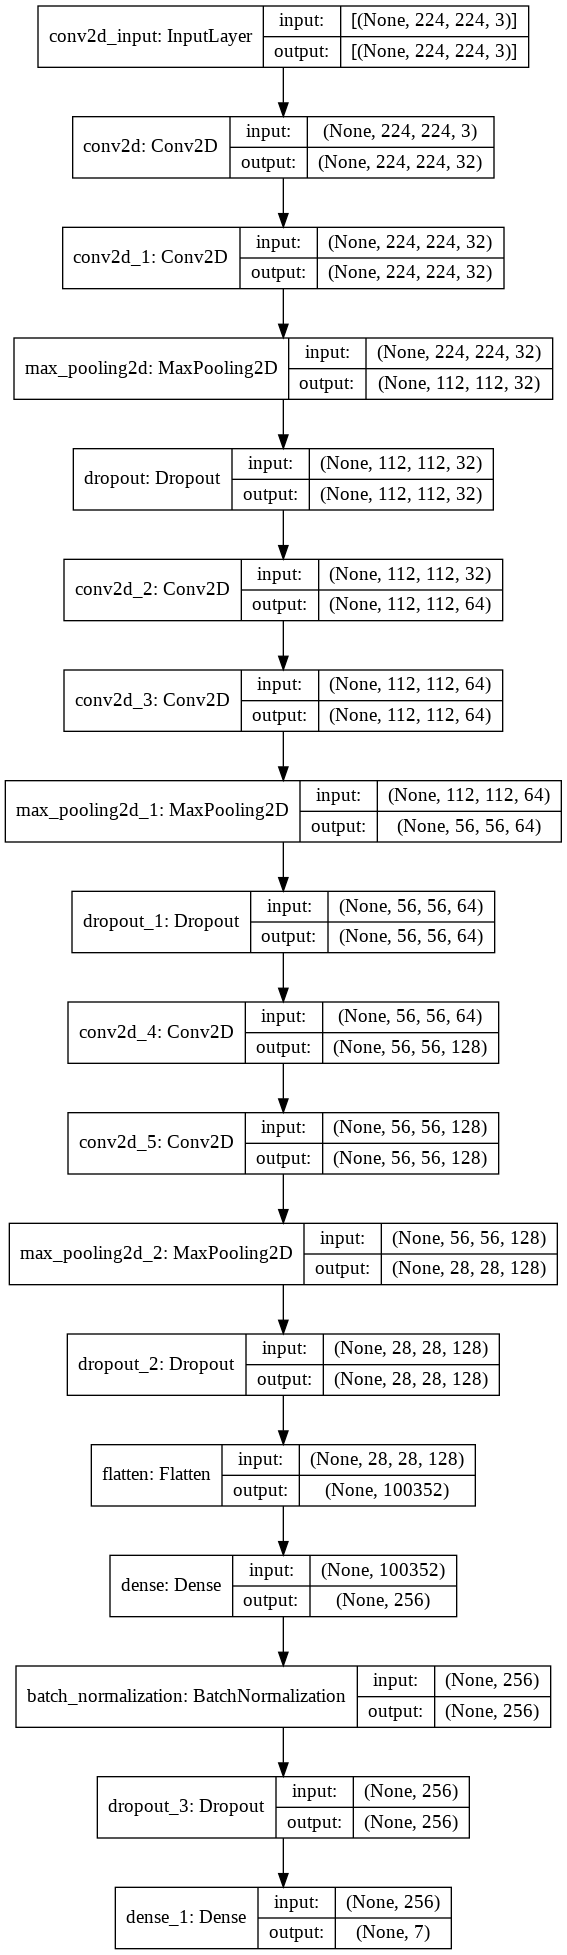

In [ ]:
plot_model(model, to_file = 'Model.png', show_shapes = True, show_layer_names = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

<font size = 5 color = 'royalblue'>
4.4.- Data Augmentation

<font size = 4 color ='black'>

Utilizamos la clase de Keras <i>__ImageDataGenerator()__</i> con el cual realizamos el aumento artificial en el preprocesamiento de datos en el Notebook 1, pero en esta ocasión con una configuración diferente.

In [ ]:
datagen = ImageDataGenerator(featurewise_center = False,
                             samplewise_center = False,
                             featurewise_std_normalization = False,
                             samplewise_std_normalization = False,
                             zca_whitening = False,
                             rotation_range = False,
                             zoom_range = False ,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = True
                            )

Sobre la clase [ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

<font size = 4 color ='black'>

Aplicamos las operaciones definidas al conjunto de entrenamiento.

In [ ]:
datagen.fit(train_x)

<font size = 5 color = 'royalblue'>
4.5.- Optimizador, función de costo e hiperparámetros.

<font size = 4 color ='black'>

Utilizaremos el optimizador <i>__Adam__</i> con los siguientes hiperparámetros.

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                beta_1 = 0.9, 
                                beta_2 = 0.999, 
                                epsilon = 1e-07,
                                amsgrad = False, 
                                name = 'Adam')

Sobre el método [optimizers.Adam()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

<font size = 4 color ='black'>

Utilizaremos la función de costo <i>__categorical_crossentropy__</i> con los siguientes hiperparámetros.

In [ ]:
categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits = False, 
                                                                   label_smoothing = 0,
                                                                   name = 'categorical_crossentropy')

Sobre el método [losses.CategoricalCrossentropy()](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)

<font size = 4 color ='black'>

Utilizaremos la métrica <i>__Accuracy__</i> la cual contabiliza la frecuencia con la que el modelo infiere correctamente la etiqueta de una muestra.

In [ ]:
accuracy = tf.keras.metrics.Accuracy(name = 'accuracy')

Sobre el método [metrics.Accuracy()](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)

Sobre las [métricas](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) disponibles en Tensorflow Keras.

<font size = 4 color ='black'>

Una vez que tenemos la arquitectura, optimizador, función de costo, métrica e hiperparámetros compilamos el modelo con el atributo de Keras <i>__Model.compile()__</i>.

In [ ]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = "accuracy")

Sobre el método [Model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

<font size = 5 color = 'royalblue'>
4.6.- Entrenamiento

<font size = 4 color ='black'>

Definimos los hiperparámetros referentes al entrenamiento como el tamaño de batch y las épocas en las que se entrenará. También aplicamos el método <i>__.flow()__</i> el cual producirá un iterador que generará batches de imágenes aumentadas durante el entrenamiento.

In [ ]:
batch_size = 128
epochs = 100

it_train = datagen.flow(train_x, train_y, seed = 10, batch_size = batch_size)

steps = int( (train_x.shape[0] + 200) / batch_size)  #El número 200 puede variar dependiendo del GPU en el que se entrene.

Sobre el método [.flow()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow)

<font size = 4 color ='black'>

Comenzamos el entrenamiento utilizando el método <i>__Model.fit()__</i>.

Sobre el método [Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [ ]:
history = model.fit(it_train, 
                    steps_per_epoch = steps, 
                    epochs = epochs, 
                    validation_data = (val_x, val_y), 
                    verbose = 1, 
                    shuffle = False)

Epoch 1/100
12/12 [==============================] - 41s 2s/step - loss: 2.2884 - accuracy: 0.2299 - val_loss: 8.4081 - val_accuracy: 0.1768
Epoch 2/100
12/12 [==============================] - 20s 2s/step - loss: 1.7255 - accuracy: 0.3518 - val_loss: 6.5034 - val_accuracy: 0.2210
Epoch 3/100
12/12 [==============================] - 20s 2s/step - loss: 1.5689 - accuracy: 0.4072 - val_loss: 3.1784 - val_accuracy: 0.3094
Epoch 4/100
12/12 [==============================] - 20s 2s/step - loss: 1.4075 - accuracy: 0.4827 - val_loss: 1.8507 - val_accuracy: 0.3702
Epoch 5/100
12/12 [==============================] - 20s 2s/step - loss: 1.2921 - accuracy: 0.5048 - val_loss: 1.1320 - val_accuracy: 0.5580
Epoch 6/100
12/12 [==============================] - 20s 2s/step - loss: 1.1192 - accuracy: 0.5672 - val_loss: 1.4131 - val_accuracy: 0.5193
Epoch 7/100
12/12 [==============================] - 20s 2s/step - loss: 1.1235 - accuracy: 0.5824 - val_loss: 1.2018 - val_accuracy: 0.5414
Epoch 8/100
1

<font size = 5 color = 'royalblue'>
4.7.- Gráficas de costo y precisión

<font size = 4 color ='black'>

Graficamos la función de costo y la presición (accuracy) para cada época a partir del entrenamiento.

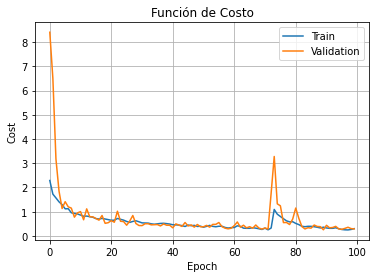

In [ ]:
#Función de Costo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.figure(figsize=(8,8)
plt.title("Función de Costo")
plt.grid()
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

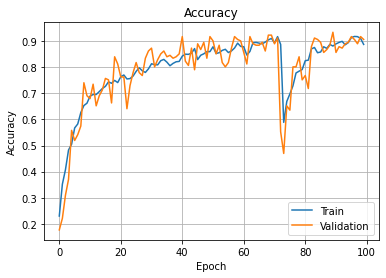

In [ ]:
#Función de presición (accuracy)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

<font size = 4 color ='black'>

Estas gráficas nos ayudan a observar rápidamente el desempeño del modelo durante el entrenamiento y la validación, lo cual nos ayuda a decidir si guardarlo o buscar mejorarlo.

<font size = 4 color ='black'>

Una vez terminado el entrenamiento y generadas las funciones de costo y presición, elegimos si guardar o no el modelo como un archivo con extensión <i>__.h5__</i>.
Lo que se guarda en este archivo son los <i>__pesos__</i> y <i>__bias__</i> obtenidos durante el entrenamiento.

In [ ]:
#Descomenta la siguiente línea si quieres guardar el modelo.

#model.save('/content/drive/MyDrive/I AM TZITÉ/Geociencia/cursoGeociencIAs/Clasificador_de_rocas_TZITE/keras_kaggle-030221/kere-refinado-argu/Version_4/Notebook_2_Clasificador_minerales/My_trained_model_mineral_clasiffier.h5')

Sobre el método [Model.save()](https://www.tensorflow.org/tutorials/keras/save_and_load#what_are_these_files)

<font size = 6 color = 'royalblue'>
5.- Métricas

<font size = 5 color = 'red'>
Ya que el entrenamiento pudiera demorar mucho tiempo, un modelo previamente entrenado pero con la misma arquitectura e hiperparámetros es incluido en la carpeta de trabajo, este se llama <i>trained_model_mineral_classifier.h5<i>.

<font size = 5 color = 'black'>
Cargamos el modelo pre entrenado con el método de Keras: <i>tf.keras.models.load_model()<i>.

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Clasificador_from_scratch/trained_model_mineral_classifier.h5')

<font size = 5 color = 'royalblue'>
5.1.- Cálculo de las métricas en el conjunto de entrenamiento

In [ ]:
out_pred_train = model.predict(train_x)

prediction_train = out_pred_train >= 0.5
        
precision_train, recall_train, fscore_train, support_train = PRFS(train_y, prediction_train)

precision_train = np.round(100*precision_train, 2)
recall_train = np.round(100*recall_train, 2)
fscore_train = np.round(100*fscore_train, 2)

cnf_matrix_train = confusion_matrix(train_y.argmax(axis=1), prediction_train.argmax(axis=1))

print("\nprecision_train: {} \n\nrecall_train: {} \n\nfscore_train: {} \n\nTotal de muestras: {}"\
      .format(precision_train, recall_train, fscore_train, support_train))


precision_train: [100.   100.   100.   100.    98.56 100.   100.  ] 

recall_train: [100.   100.    99.42 100.   100.   100.    99.07] 

fscore_train: [100.   100.    99.71 100.    99.28 100.    99.53] 

Total de muestras: [187 265 172 208 206 192 214]


Sobre el método [precision_recall_fscore_support()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

<font size = 5 color = 'black'>
Matriz de confusión para el conjunto de entrenamiento

In [ ]:
dic = {0 : "muscovite",
       1 : "malachite",
       2 : "biotite",
       3 : "chrysocolla",
       4 : "pyrite",
       5 : "quartz",
       6 : "bornite"}

In [ ]:
list_clases = []
for classe in dic:
  list_clases.append(dic[classe])

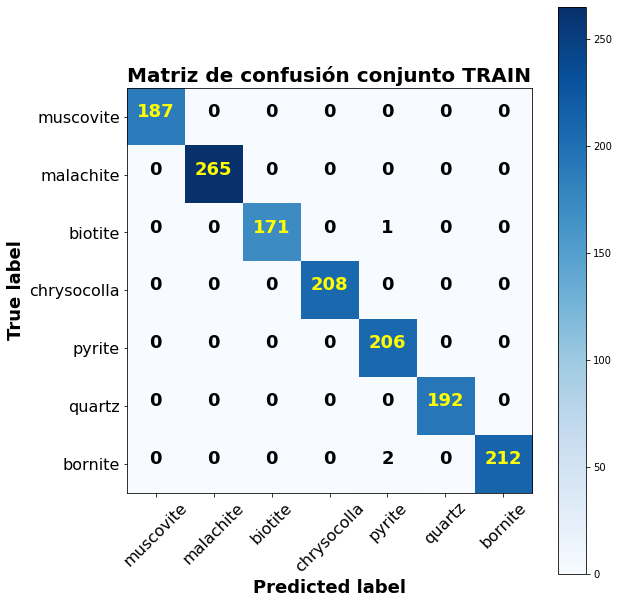

In [ ]:
cm = cnf_matrix_train
classes = list_clases
cmap = plt.cm.Blues
title='Matriz de confusión conjunto TRAIN'
normalize = False


plt.rcParams['figure.figsize']=(9,9)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title, fontsize=20, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
plt.yticks(tick_marks, classes, fontsize=16)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment="center",
    color="yellow" if cm[i, j] > thresh else "black",
    fontsize=18, fontweight='bold')

plt.ylabel('True label', fontsize=18, fontweight='bold')
plt.xlabel('Predicted label', fontsize=18, fontweight='bold')
plt.tight_layout()

<font size = 5 color = 'royalblue'>
5.2.- Cálculo de las métricas en el conjunto de prueba

In [ ]:
out_pred_test = model.predict(predictions)

prediction_test = out_pred_test >= 0.5
        
precision_test, recall_test, fscore_test, support_test = PRFS(test_y, prediction_test)

precision_test = np.round(100*precision_test, 2)
recall_test = np.round(100*recall_test, 2)
fscore_test = np.round(100*fscore_test, 2)

cnf_matrix_test = confusion_matrix(test_y.argmax(axis = 1), prediction_test.argmax(axis = 1))

print("\nprecision_train: {} \n\nrecall_train: {} \n\nfscore_train: {} \n\nTotal de muestras: {}"\
      .format(precision_test, recall_test, fscore_test, support_test))

ValueError: ignored

<font size = 5 color = 'black'>
Matriz de confusión para el conjunto de prueba

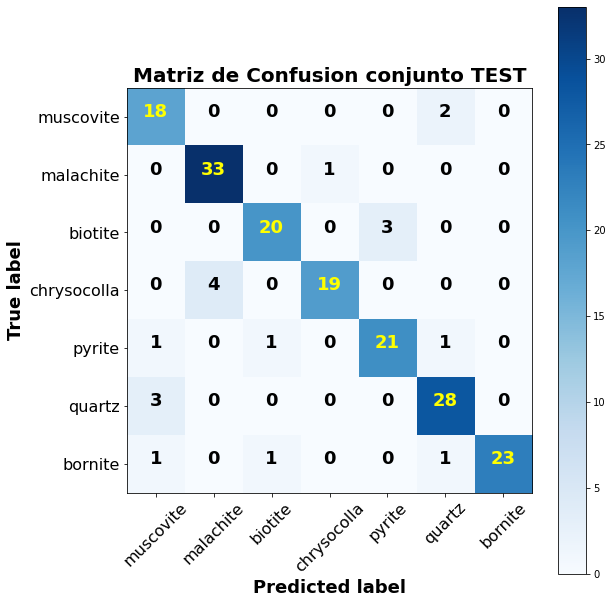

In [ ]:
cm = cnf_matrix_test
classes = list_clases
cmap = plt.cm.Blues
title = 'Matriz de Confusion conjunto TEST'
normalize = False


plt.rcParams['figure.figsize']=(9,9)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title, fontsize=20, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
plt.yticks(tick_marks, classes, fontsize=16)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment="center",
    color="yellow" if cm[i, j] > thresh else "black",
    fontsize=18, fontweight='bold')

plt.ylabel('True label', fontsize=18, fontweight='bold')
plt.xlabel('Predicted label', fontsize=18, fontweight='bold')
plt.tight_layout()

In [ ]:
test_x.shape

(181, 224, 224, 3)

<font size = 6 color = 'royalblue'>
6.- Inferencias

<font size = 5 color = 'black'>
Cargamos el dataframe <i>images_for_inferences.pkl</i> el cual contiene las imágenes, ya convertidas a arreglos, para hacer su inferencia.
Estas imágenes fueron extraidas desde el navegador y no pertenecen a la base de datos.

In [ ]:
df_inferences = pd.read_pickle('/content/drive/MyDrive/Clasificador_from_scratch/images_for_inferences.pkl' )

print("\nEl dataframe con los arreglos correspondientes a las imágenes para hacer inferencia tiene {} arreglos."\
      .format(len(df_inferences)))


El dataframe con los arreglos correspondientes a las imágenes para hacer inferencia tiene 33 arreglos.


In [ ]:
df_inferences.shape

(33, 2)

In [ ]:
df_inferences

KeyboardInterrupt: ignored

<font size = 5 color = 'black'>
Comprobamos que las imágenes tengan las dimensiones adecuadas.

In [ ]:
imagenes_inf = np.array( df_inferences["images"][:] )

images_accurate = []
images_with_issues = []
index_inf = []

for i in range(len(imagenes_inf)):
    if imagenes_inf[i].shape != (224,224,3):
        
            image = imagenes_inf[i]   
            images_with_issues.append(image)
            index_inf.append(i)
    
        
    image = imagenes_inf[i]   
    images_accurate.append(image)
    
print("Los índices de las imágenes con errores son: {}. En total {} imágenes a eliminar."\
      .format(index_inf, len(images_with_issues)))

Los índices de las imágenes con errores son: []. En total 0 imágenes a eliminar.


<font size = 5 color = 'black'>
Eliminamos las imágenes con dimensiones diferentes

In [ ]:
for i in range(len(index_inf)):
    df_inferences = df_inferences.drop(index_inf[i])
    
print("El nuevo tamaño del Dataframe es {}".format(len(df_inferences)))

El nuevo tamaño del Dataframe es 33


<font size = 5 color = 'black'>
Almacenamos las imágenes en un arreglo para normalizarlo.

In [ ]:
images_test = np.array(df_inferences["images"][:])
d = []
for i in range(len(images_test)):
    image = images_test[i]   
    d.append(image)

In [ ]:
predictions = np.array(d)
predictions.shape

(33, 224, 224, 3)

In [ ]:
predictions = predictions / 255
predictions[5][0][0]

array([0.76862745, 0.77647059, 0.75686275])

In [ ]:
predictions.shape

(33, 224, 224, 3)

<font size = 5 color = 'black'>
Definimos la siguiente función para cambiar las etiquetas de One-hot encoding a dígito.

In [ ]:
def non_hot(yPred):
    labels=[]
    for i in range(len(yPred)):
        max=np.max(yPred[i])
        for j in range(7):
            if (yPred[i][j]==max):
                yPred[i][j]=1
                labels.append(j)
            else:
                yPred[i][j]=0
                
    return labels

<font size = 5 color = 'black'>

Hacemos la inferencia con el atributo <i>__Model.predict()__</i> de Keras.

In [ ]:
inferences = model.predict(predictions)
inferences.shape

(33, 7)

In [ ]:
inferences_no_encoding = non_hot(inferences)
inferences_no_encoding

[5,
 5,
 5,
 5,
 5,
 6,
 4,
 6,
 0,
 6,
 2,
 4,
 2,
 2,
 4,
 0,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 4,
 0,
 0,
 3,
 3,
 3,
 3,
 1]

<font size = 5 color = 'black'>
Comprobamos las inferencias

In [ ]:
for i in range(len(predictions)):
  plt.imshow(predictions[i])
  plt.show()
  print('La predicción para el mineral ', i, 'es ', dic[inferences_no_encoding[i]])
  print("\n En Realidad, el mineral es del tipo ", df_inferences["file_name"][i])

Output hidden; open in https://colab.research.google.com to view.